## 4.3 Convolutional Neural Networks

A convolutional neural network (CNN) is an artificial neural network commonly used in vision tasks. The use of convolutional layers allows CNNs to be very efficient regarding the amount of computation required, making them suitable for use on large datasets or devices with limited computing resources.



### Data preparation

1. Import the required packages and set the class number as 10 and test size as 0.2.

In [ ]:
import os
import numpy as np
from os import listdir
from imageio import imread
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils.image_utils import img_to_array
import PIL
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from matplotlib import pyplot as plt

drive.mount('/content/drive')
# Settings 
num_classes = 10
test_size = 0.2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Get dataset from picture and then split to train and test set, and convert image to 3d array.

In [ ]:
def get_img(data_path): 
  ## Getting image array from path: 
  img = PIL.Image.open(data_path)
  img = img.convert("L")
  img = img_to_array(img)
  img = np.resize(img, (100, 100, 1))
  return img

In [ ]:
dataset_path = "/content/drive/MyDrive/4050final/Dataset"

## Getting all data from data path
labels = sorted(listdir(dataset_path))
X = []
Y = []
for i, label in enumerate(labels): 
  data_path = dataset_path + "/" + label
  
  for data in listdir(data_path): 
    img = get_img(data_path + "/" + data)
    X.append(img)
    Y.append(i)
## create dataset 
X = 1 - np.array(X).astype("float32") /255
Y = np.array(Y).astype("float32")
Y = to_categorical(Y, num_classes)

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=test_size, random_state = 42)
print(X.shape)
print(X_test.shape)
print(Y.shape)
print(Y_test.shape)


(130, 100, 100, 1)
(33, 100, 100, 1)
(130, 10)
(33, 10)


In [ ]:
#Unzip data
!unzip -q './drive/MyDrive/4050final/Dataset.zip'

replace __MACOSX/._Dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
img_height = 100
img_width = 100
batch_size = 128

3. Load data using Keras Utils so that they could be further used in the CNN model.

In [ ]:
#Load data using keras utils
train_ds = tf.keras.utils.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2062 files belonging to 10 classes.
Using 1650 files for training.
Found 2062 files belonging to 10 classes.
Using 412 files for validation.


4. Check the class and image that to make sure they are prepared to be fitted in the model.

In [ ]:
#Print class names
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


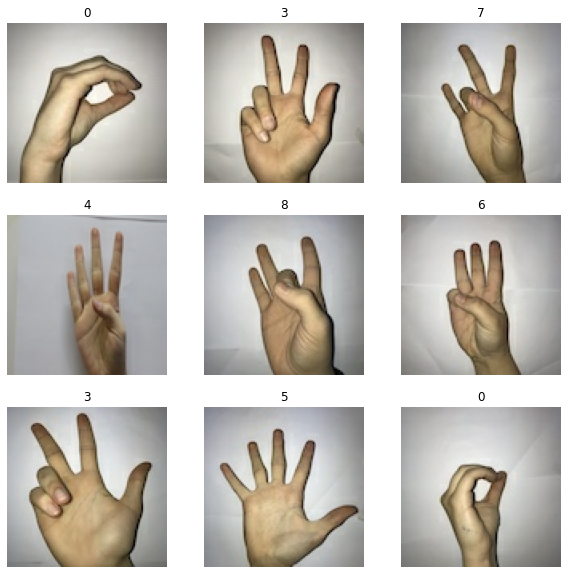

In [ ]:
#Plot images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Build model

1. Build an initial model. The first layer is a Rescaling layer that scales the input data by dividing each value by 255, a common preprocessing step that helps standardize the data. The next four layers are Conv2D, convolutional layers used for image classification. The activation argument specifies the activation function to use, in this case 'relu' (rectified linear unit).
The model also includes four MaxPooling2D layers, which downsize the data by taking the maximum value over a certain window size specified by the pool_size argument. This helps reduce the size of the data and can also help reduce overfitting.
The Flatten layer flattens the data into a one-dimensional array, which is necessary before passing it through a Dense layer. The model has two Dense layers, fully connected (dense) layers that apply weights to the input data and produce an output. The first Dense layer has 128 units, and the second has num_classes units, the number of classes in the dataset. The final layer does not have an activation function, as it outputs the logits for each class.

In [ ]:
num_classes = len(class_names)
#Build model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), #Standardize the data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

2. In this case, the 'adam' optimizer is used, a popular choice for many tasks. And also, the SparseCategoricalCrossentropy loss function is used, a cross-entropy loss function suitable for multi-class classification tasks where the classes are mutually exclusive.

In [ ]:
#from_logits should be set to true since softmax was not used in the last output layer
#If softmax is used in the output layer then from_logits should be set to false (which is the default)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 64)       

### Check the performance of the initial model and tuning parameters.

1. As the training progresses, we can see that the loss decreases and the accuracy increases for both the training and the validation data. This is a good sign that the model is learning and generalizing well to new data; after 20 epochs, the validation accuracy is 0.9053.

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/20
13/13 [==============================] - 18s 1s/step - loss: 2.2991 - accuracy: 0.1497 - val_loss: 2.2129 - val_accuracy: 0.3398
Epoch 2/20
13/13 [==============================] - 18s 1s/step - loss: 1.9405 - accuracy: 0.4127 - val_loss: 1.4555 - val_accuracy: 0.4709
Epoch 3/20
13/13 [==============================] - 18s 1s/step - loss: 1.0894 - accuracy: 0.6309 - val_loss: 0.7665 - val_accuracy: 0.7233
Epoch 4/20
13/13 [==============================] - 20s 2s/step - loss: 0.7858 - accuracy: 0.7267 - val_loss: 0.6319 - val_accuracy: 0.7937
Epoch 5/20
13/13 [==============================] - 18s 1s/step - loss: 0.6190 - accuracy: 0.7879 - val_loss: 0.5539 - val_accuracy: 0.8107
Epoch 6/20
13/13 [==============================] - 18s 1s/step - loss: 0.5141 - accuracy: 0.8315 - val_loss: 0.4943 - val_accuracy: 0.8568
Epoch 7/20
13/13 [==============================] - 18s 1s/step - loss: 0.4328 - accuracy: 0.8606 - val_loss: 0.4560 - val_accuracy: 0.8592
Epoch 8/20
13/13 [==

2. Then, we plot the training and validation accuracy and loss. We find that when the epoch is 7~8, the increase in validation accuracy starts to slow down significantly, and the decrease in validation loss also slows down significantly. 

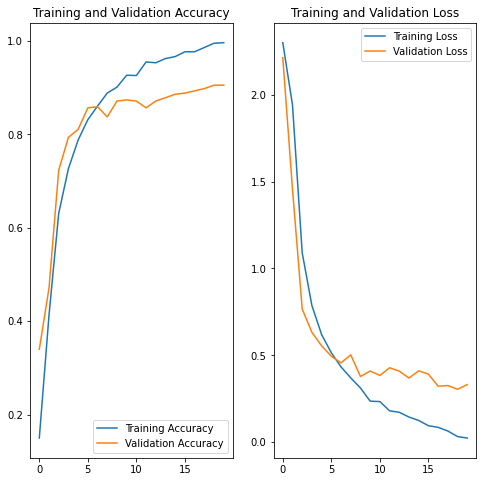

In [ ]:
#Plot training and test accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
score = model.evaluate(test_ds)
print("Network test score [loss, accuracy]:", score)

4/4 [==============================] - 1s 279ms/step - loss: 0.4338 - accuracy: 0.8568
Network test score [loss, accuracy]: [0.4338451623916626, 0.856796145439148]


3. Then we do Adam with learning rate decay. we set the initial_learning_rate and decay_rate and decay step by ourselves. Using a learning rate schedule can help the model converge faster and can also help prevent overfitting. It allows the model to start with a larger learning rate and gradually reduce it as the training progresses. This can help the model escape from local minima and find a better solution.

In [ ]:
num_classes = len(class_names)
#Build model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), #Standardize the data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
opt = keras.optimizers.Adam(learning_rate = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate = 5e-3, 
  decay_rate = 0.96, 
  decay_steps = 1500, 
))

In [ ]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=8
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/8
13/13 [==============================] - 18s 1s/step - loss: 2.6153 - accuracy: 0.1394 - val_loss: 2.2455 - val_accuracy: 0.3252
Epoch 2/8
13/13 [==============================] - 18s 1s/step - loss: 1.8071 - accuracy: 0.3891 - val_loss: 1.0810 - val_accuracy: 0.6359
Epoch 3/8
13/13 [==============================] - 19s 1s/step - loss: 0.9437 - accuracy: 0.6848 - val_loss: 0.7610 - val_accuracy: 0.7573
Epoch 4/8
13/13 [==============================] - 22s 2s/step - loss: 0.7181 - accuracy: 0.7612 - val_loss: 0.7087 - val_accuracy: 0.7500
Epoch 5/8
13/13 [==============================] - 20s 1s/step - loss: 0.5762 - accuracy: 0.8079 - val_loss: 0.6989 - val_accuracy: 0.7573
Epoch 6/8
13/13 [==============================] - 20s 2s/step - loss: 0.5669 - accuracy: 0.7994 - val_loss: 0.4881 - val_accuracy: 0.8422
Epoch 7/8
13/13 [==============================] - 18s 1s/step - loss: 0.4315 - accuracy: 0.8576 - val_loss: 0.5718 - val_accuracy: 0.8107
Epoch 8/8
13/13 [==========

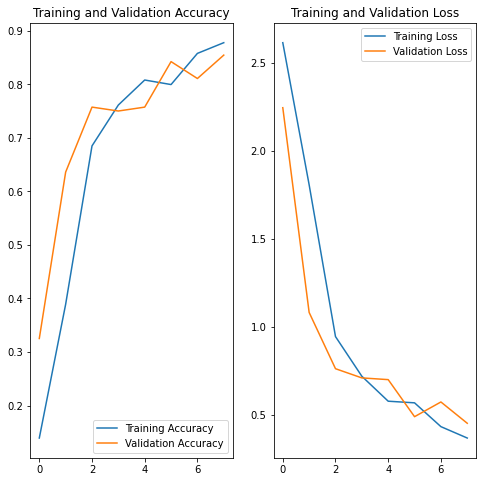

In [ ]:
#Plot training and test accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

4. Checking the loss curve, we found that the fluctuation of the validation curve decreased, so we further reduced the learning rate

In [ ]:
num_classes = len(class_names)
#Build model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), #Standardize the data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
opt = keras.optimizers.Adam(learning_rate = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate = 5e-4, 
  decay_rate = 0.96, 
  decay_steps = 1500, 
))

In [ ]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 8
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/8
13/13 [==============================] - 19s 1s/step - loss: 2.3116 - accuracy: 0.1055 - val_loss: 2.2941 - val_accuracy: 0.1068
Epoch 2/8
13/13 [==============================] - 20s 1s/step - loss: 2.2615 - accuracy: 0.2588 - val_loss: 2.2078 - val_accuracy: 0.4248
Epoch 3/8
13/13 [==============================] - 21s 2s/step - loss: 2.0607 - accuracy: 0.4933 - val_loss: 1.8326 - val_accuracy: 0.5194
Epoch 4/8
13/13 [==============================] - 18s 1s/step - loss: 1.4571 - accuracy: 0.6212 - val_loss: 1.1043 - val_accuracy: 0.6214
Epoch 5/8
13/13 [==============================] - 20s 1s/step - loss: 0.9077 - accuracy: 0.7006 - val_loss: 0.7173 - val_accuracy: 0.7476
Epoch 6/8
13/13 [==============================] - 19s 1s/step - loss: 0.6886 - accuracy: 0.7745 - val_loss: 0.6401 - val_accuracy: 0.7694
Epoch 7/8
13/13 [==============================] - 18s 1s/step - loss: 0.6020 - accuracy: 0.8055 - val_loss: 0.5873 - val_accuracy: 0.8083
Epoch 8/8
13/13 [==========

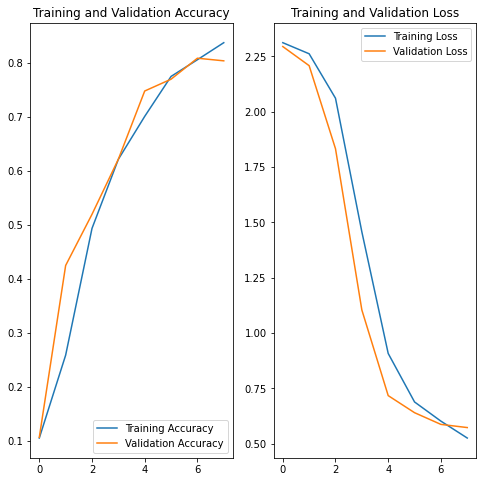

In [ ]:
#Plot training and test accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This time, we saw a smooth decline in the loss curve, indicating that our learning rate was selected appropriately, and the accuracy of the training set was not much different from that of the test set. Therefore, the parameter tuning of the model comes to an end. The accuracy of the test set is 0.803.

In [ ]:
score = model.evaluate(test_ds)
print("Network test score [loss, accuracy]:", score)

4/4 [==============================] - 1s 271ms/step - loss: 0.5730 - accuracy: 0.8034
Network test score [loss, accuracy]: [0.5729589462280273, 0.803398072719574]
